# VQE Benchmark Suite for Lithium Hydride (LiH) - Frozen Core Version (8 Qubits)

This notebook implements a **comprehensive benchmark framework** to compare multiple ansatz implementations for VQE.

**Framework Features:**
- Tests 4 different ansatz implementations
- Runs each ansatz 3 times for statistical reliability
- Tracks comprehensive metrics for each run
- Aggregates results into comparison tables and visualizations

**Ansätze to Compare:**
1. **UCCSD** - Unitary Coupled Cluster Singles and Doubles
2. **Hardware Efficient** - Parameterized rotation layers
3. **TwoLocal** - General two-local ansatz
4. **Custom Ansatz** - To be implemented

**Metrics Tracked:**
- Circuit complexity (CNOT count, depth, parameters)
- Convergence speed and quality
- State fidelity to exact ground state
- Variance behavior
- Barren plateau indicators


In [1]:
# Install required packages
!pip install --upgrade qiskit qiskit-nature qiskit-algorithms pyscf matplotlib -q

In [2]:
# Import required libraries
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD, UCC
from qiskit.circuit.library import ExcitationPreserving 
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, state_fidelity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from typing import Dict, List, Any

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Step 1: Define LiH Molecule with Frozen Core

In [3]:
# Define LiH molecule
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.595",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Run electronic structure calculation
problem_full = driver.run()

print(f"Before freeze-core:")
print(f"  Spatial orbitals: {problem_full.num_spatial_orbitals}")
print(f"  Particles:        {problem_full.num_particles}")
print(f"  Qubits:           {problem_full.num_spatial_orbitals * 2}\n")

# Apply frozen core approximation
transformer = FreezeCoreTransformer(
    freeze_core=True,
    #remove_orbitals=[4, 5]
    remove_orbitals=[5]  # Remove 2 high-energy orbitals: 6→4 spatial orbitals
)
problem = transformer.transform(problem_full)

print(f"After freeze-core:")
print(f"  Spatial orbitals: {problem.num_spatial_orbitals}")
print(f"  Particles:        {problem.num_particles}")
print(f"  Qubits:           {problem.num_spatial_orbitals * 2} ✅ (Target: 8)")
print(f"  Nuclear repulsion: {problem.nuclear_repulsion_energy:.6f} Ha")

Before freeze-core:
  Spatial orbitals: 6
  Particles:        (2, 2)
  Qubits:           12

After freeze-core:
  Spatial orbitals: 4
  Particles:        (1, 1)
  Qubits:           8 ✅ (Target: 8)
  Nuclear repulsion: 0.995318 Ha


## Step 2: Get Hamiltonian and Map to Qubits


In [4]:
# Get Hamiltonian from reduced problem
hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

# Map to qubit operator
mapper = JordanWignerMapper()
qubit_op = mapper.map(second_q_op)

print(f"Fermionic operator has {len(second_q_op)} terms")
print(f"Qubit operator has {len(qubit_op)} terms")
print(f"Number of qubits: {qubit_op.num_qubits}")


Fermionic operator has 300 terms
Qubit operator has 105 terms
Number of qubits: 8


## Step 3: Exact Solution (NumPy Solver)


In [5]:
# Exact solver for reference
numpy_solver = NumPyMinimumEigensolver()
numpy_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

exact_electronic = numpy_result.eigenvalue.real
exact_total = exact_electronic + problem.nuclear_repulsion_energy

# Get exact ground state vector for fidelity calculation
exact_state = numpy_result.eigenstate

print("Exact Solution (NumPy):")
print(f"  Electronic energy: {exact_electronic:.8f} Ha")
print(f"  Total energy:      {exact_total:.8f} Ha")


Exact Solution (NumPy):
  Electronic energy: -1.06086814 Ha
  Total energy:      -0.06555051 Ha


## Step 4: Define Benchmark Framework and Ansatz Configurations


In [ ]:
def run_vqe_benchmark(ansatz, ansatz_name, run_number, qubit_op, exact_electronic, exact_state, problem, maxiter=300):
    """
    Run a single VQE benchmark with comprehensive metric tracking
    FIXED: Robust error handling in callback
    """
    
    # Get circuit metrics
    circuit = ansatz.decompose()
    num_parameters = ansatz.num_parameters
    circuit_depth = circuit.depth()
    circuit_size = circuit.size()
    cnot_count = circuit.count_ops().get('cx', 0)


    print(f"\n{'='*70}")
    print(f"Running: {ansatz_name} - Run #{run_number}")
    print(f"Optimizer: COBYLA (maxiter={maxiter})")
    print(f"Parameters: {num_parameters}, Depth: {circuit_depth}")
    print(f"{'='*70}")

    start_time = time.time() #moved here now

    
    # Initialize tracking lists
    convergence_history = []
    all_evaluations = []
    variance_history = []
    
    best_energy = [float('inf')]
    callback_error_count = [0]
    
    def callback(eval_count, parameters, mean, std):
        """Callback with robust error handling"""
        try:
            # Store all evaluations
            all_evaluations.append(mean)
            
            # Update best-so-far
            if mean < best_energy[0]:
                best_energy[0] = mean
            
            # Store best-so-far for convergence
            convergence_history.append(best_energy[0])
            
            # Extract variance (simplified - don't let this fail)
            try:
                if isinstance(std, dict):
                    variance_val = list(std.values())[0] if len(std) > 0 else 0.0
                else:
                    variance_val = std if std is not None else 0.0
                variance_history.append(variance_val)
            except:
                variance_history.append(0.0)
            
            # Print progress every 50 evaluations
            if len(all_evaluations) % 50 == 0:
                print(f"    Eval {len(all_evaluations)}: E={mean:.6f} Ha, " +
                      f"Error={abs(mean - exact_electronic)*1000:.3f} mHa")
        
        except Exception as e:
            # Count errors but don't let callback crash VQE
            callback_error_count[0] += 1
            if callback_error_count[0] == 1:  # Only print first error
                print(f"    ⚠️  Callback error: {e}")
    
    # Run VQE with COBYLA optimizer
    vqe_solver = VQE(
        StatevectorEstimator(), 
        ansatz, 
        COBYLA(maxiter=maxiter, tol=1e-6),
        callback=callback
    )
    
    # Use small random initialization
    np.random.seed(42 + run_number)
    vqe_solver.initial_point = np.random.normal(0, 0.01, size=ansatz.num_parameters)
    
    print(f"⏱️  Starting VQE optimization now...")  # debug
    vqe_start = time.time()  # debug
    
    result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
    
    vqe_end = time.time()  # debug
    print(f"⏱️  VQE compute_minimum_eigenvalue took: {vqe_end - vqe_start:.1f}s")  # debug

    vqe_electronic = result.eigenvalue.real
    vqe_total = vqe_electronic + problem.nuclear_repulsion_energy
    elapsed_time = time.time() - start_time
    
    # Get actual number of function evaluations
    actual_evals = getattr(result.optimizer_result, 'nfev', len(convergence_history))
    
    print(f"\n✅ Completed in {elapsed_time:.1f}s")
    print(f"   Function evaluations: {actual_evals}")
    print(f"   Callback captured: {len(convergence_history)} points")
    if callback_error_count[0] > 0:
        print(f"   Callback errors: {callback_error_count[0]}")
    
    # Calculate convergence speed
    if len(convergence_history) > 1:
        energy_range = convergence_history[0] - exact_electronic
        threshold_energy = convergence_history[0] - 0.99 * energy_range
        convergence_iter = next((i for i, e in enumerate(convergence_history) 
                                if e <= threshold_energy), len(convergence_history))
    else:
        convergence_iter = actual_evals
    
    # Calculate final state fidelity
    try:
        optimal_params = result.optimal_parameters
        if optimal_params is not None:
            param_dict = {param: optimal_params[param] for param in ansatz.parameters}
            bound_circuit = ansatz.assign_parameters(param_dict)
        else:
            bound_circuit = ansatz.assign_parameters(vqe_solver.initial_point)
        
        final_vqe_state = Statevector(bound_circuit)
        final_fidelity = state_fidelity(final_vqe_state, exact_state)
    except Exception as e:
        print(f"   ⚠️  Fidelity calculation failed: {e}")
        final_fidelity = 0.0
    
    # Calculate final metrics
    final_energy_error = abs(vqe_electronic - exact_electronic)
    final_energy_error_percent = (final_energy_error / abs(exact_electronic)) * 100
    
    print(f"   Energy Error: {final_energy_error:.6e} Ha ({final_energy_error_percent:.4f}%)")
    print(f"   Fidelity: {final_fidelity:.6f}")
    print(f"   Convergence: {convergence_iter}/{len(convergence_history)} iterations")
    
    # Plot convergence on second run (only if we have data)
    if run_number == 2 and len(convergence_history) > 1:
        print(f"\n{'*'*70}")
        print(f"📊 PLOTTING CONVERGENCE FOR {ansatz_name} - RUN #2")
        print(f"{'*'*70}\n")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        iterations = range(1, len(convergence_history) + 1)
        
        # Plot 1: Energy convergence
        ax1.plot(iterations, convergence_history, 'b-', linewidth=2, alpha=0.7, label='VQE Energy')
        ax1.axhline(y=exact_electronic, color='r', linestyle='--', linewidth=2, label='Exact Energy')
        ax1.set_xlabel('Iteration', fontsize=12)
        ax1.set_ylabel('Electronic Energy (Ha)', fontsize=12)
        ax1.set_title(f'{ansatz_name} - Energy Convergence (Run #2)', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Absolute error (log scale)
        absolute_errors = [abs(energy - exact_electronic) for energy in convergence_history]
        ax2.semilogy(iterations, absolute_errors, 'g-', linewidth=2, alpha=0.7)
        ax2.set_xlabel('Iteration', fontsize=12)
        ax2.set_ylabel('Absolute Energy Error (Ha)', fontsize=12)
        ax2.set_title(f'{ansatz_name} - Error Convergence (Run #2)', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, which='both')
        
        plt.tight_layout()
        plot_filename = f"convergence_{ansatz_name}_run2.png"
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✅ Convergence plot saved: {plot_filename}\n")
    
    # Return comprehensive results
    return {
        'Ansatz': ansatz_name,
        'Run': run_number,
        'CNOT_Count': cnot_count,
        'Circuit_Depth': circuit_depth,
        'Circuit_Size': circuit_size,
        'Num_Parameters': num_parameters,
        'Total_Iterations': len(convergence_history) if len(convergence_history) > 0 else actual_evals,
        'Convergence_Speed_99': convergence_iter,
        'Total_Time_sec': elapsed_time,
        'Initial_Energy_Ha': convergence_history[0] if len(convergence_history) > 0 else vqe_electronic,
        'Final_Energy_Ha': convergence_history[-1] if len(convergence_history) > 0 else vqe_electronic,
        'Exact_Energy_Ha': exact_electronic,
        'Energy_Error_Ha': final_energy_error,
        'Energy_Error_Percent': final_energy_error_percent,
        'State_Fidelity': final_fidelity,
        'Fidelity_Percent': final_fidelity * 100,
        'Avg_Variance': np.mean(variance_history) if len(variance_history) > 0 else 0.0,
        'Final_Variance': np.mean(variance_history[-100:]) if len(variance_history) > 100 else 0.0,
        'Max_Variance': max(variance_history) if len(variance_history) > 0 else 0.0,
        'Min_Variance': min(variance_history) if len(variance_history) > 0 else 0.0,
        'Gradient_Indicator': 0.0,
        'Mean_Gradient': 0.0,
        'Std_Gradient': 0.0,
        'Barren_Plateau_Status': 'N/A',
        # Store histories
        '_convergence_history': convergence_history,
        '_variance_history': variance_history,
        '_fidelity_history': [],
        '_gradient_history': []
    }

print("✅ Benchmark framework defined w/ debugging")

✅ Benchmark framework defined w/ debugging


## Step 5: Define Individual Ansätze (4 Different Implementations)


In [7]:
# Get problem parameters
num_qubits = problem.num_spatial_orbitals * 2
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

print(f"System parameters:")
print(f"  Number of qubits: {num_qubits}")
print(f"  Spatial orbitals: {num_spatial_orbitals}")
print(f"  Particles: {num_particles}")
print(f"\n{'='*70}")

# Create Hartree-Fock initial state (used by all ansätze)
hf_state = HartreeFock(
    num_spatial_orbitals,
    num_particles,
    mapper,
)

print("\n✅ Hartree-Fock initial state created")
print(f"   HF state qubits: {hf_state.num_qubits}")
print(f"\n{'='*70}\n")


System parameters:
  Number of qubits: 8
  Spatial orbitals: 4
  Particles: (1, 1)


✅ Hartree-Fock initial state created
   HF state qubits: 8




In [8]:
# =============================================================================
# ANSATZ 1: UCCSD (Unitary Coupled Cluster Singles and Doubles)
# =============================================================================
print("Creating Ansatz 1: UCCSD")
print("-" * 70)

ansatz_1_UCCSD = UCCSD(
    num_spatial_orbitals,
    num_particles,
    mapper,
    initial_state=hf_state,
)

print(f"✅ UCCSD ansatz created")
print(f"   Parameters: {ansatz_1_UCCSD.num_parameters}")
print(f"   Qubits: {ansatz_1_UCCSD.num_qubits}")

# =============================================================================
# ANSATZ 2: UpCCGSD
# =============================================================================
print(f"\n{'='*70}")
print("Creating Ansatz 2: UpCCGSD: k = 2")
print("-" * 70)

def generate_upccgsd_excitations(num_spatial_orbitals, num_particles):
    """
    Generates the precise list of excitations for the UpCCGSD ansatz.
    """
    excitations = []
    
    # Loop over all unique pairs of spatial orbitals (p, q)
    for p in range(num_spatial_orbitals):
        for q in range(p + 1, num_spatial_orbitals):
            
            # 1. Generalized Singles (Spin-conserving): p -> q
            # Alpha: (2p,) -> (2q,)
            excitations.append(((2 * p,), (2 * q,)))
            # Beta: (2p+1,) -> (2q+1,)
            excitations.append(((2 * p + 1,), (2 * q + 1,)))

            # 2. Generalized Pair Doubles (Zero-seniority)
            # Annihilate pair in p (2p, 2p+1), Create pair in q (2q, 2q+1)
            excitations.append(((2 * p, 2 * p + 1), (2 * q, 2 * q + 1)))
            
    return excitations

# Create the Exact UpCCGSD Ansatz manually
k_layers = 2 

ansatz_2_UpCCGSD = UCC(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    qubit_mapper=mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
    # CORRECTED: Pass the function object, DO NOT call it ()
    excitations=generate_upccgsd_excitations,
    reps=k_layers 
)

print(f"✅ UpCCGSD ansatz created")
print(f"   Parameters: {ansatz_2_UpCCGSD.num_parameters}")
print(f"   Qubits: {ansatz_2_UpCCGSD.num_qubits}")
print(f"   Reps: 3, Entanglement: linear")

# =============================================================================
# ANSATZ 3: TwoLocal (RY-RZ rotations with CX entanglement)
# =============================================================================
print(f"\n{'='*70}")
print("Creating Ansatz 3: PC-HEA")
print("-" * 70)

# TODO: Customize this ansatz as needed

# Create particle-conserving hardware-efficient ansatz (PC-HEA)
ansatz_3_PC_HEA = ExcitationPreserving(
    num_qubits=qubit_op.num_qubits,
    mode="fsim",          # particle-conserving entangling gate
    entanglement="linear",   # fully connected entanglement
    reps=4,                # depth; increase if you want more expressivity
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

# Prepend Hartree-Fock initial state
# HF state already set via initial_state parameter - no need to compose again

print(f"✅ PC-HEA ansatz created")
print(f"   Parameters: {ansatz_3_PC_HEA.num_parameters}")
print(f"   Qubits: {ansatz_3_PC_HEA.num_qubits}")
print(f"   Mode: fsim (Particle Conserving)")
print(f"   Entanglement: linear, Reps: 4")

print(f"\n{'='*70}\n")

# =============================================================================
# ANSATZ 4: QEB (Qubit Excitation-Based)
# =============================================================================
print(f"\n{'='*70}")
print("Creating Ansatz 4: QEB (Qubit Excitation-Based)")
print("-" * 70)

from qeb_ansatz import QEBansatz

ansatz_4_QEB_8q = QEBansatz(
    num_qubits=num_qubits,
    num_particles=num_particles,
    num_spatial_orbitals=num_spatial_orbitals,
    depth=1,
    include_double=True,
    use_hartree_fock_init=True,
    mapper=mapper,
)

print(f"✅ QEB_8q ansatz created")
print(f"   Parameters: {ansatz_4_QEB_8q.num_parameters}")
print(f"   Qubits: {ansatz_4_QEB_8q.num_qubits}")
print(f"   Depth: 1")
print(f"   Single excitations: {len(ansatz_4_QEB_8q.single_excitations)}")
print(f"   Double excitations: {len(ansatz_4_QEB_8q.double_excitations)}")

print(f"\n{'='*70}\n")
print("🎯 4 ansätze created (all using 8-qubit Hamiltonian)") 



Creating Ansatz 1: UCCSD
----------------------------------------------------------------------
✅ UCCSD ansatz created
   Parameters: 15
   Qubits: 8

Creating Ansatz 2: UpCCGSD: k = 2
----------------------------------------------------------------------
✅ UpCCGSD ansatz created
   Parameters: 36
   Qubits: 8
   Reps: 3, Entanglement: linear

Creating Ansatz 3: PC-HEA
----------------------------------------------------------------------
✅ PC-HEA ansatz created
   Parameters: 96
   Qubits: 8
   Mode: fsim (Particle Conserving)
   Entanglement: linear, Reps: 4



Creating Ansatz 4: QEB (Qubit Excitation-Based)
----------------------------------------------------------------------
✅ QEB_8q ansatz created
   Parameters: 50
   Qubits: 8
   Depth: 1
   Single excitations: 12
   Double excitations: 38


🎯 4 ansätze created (all using 8-qubit Hamiltonian)


/var/folders/54/sksfdtfn0s1c8w70qkdglf5r0000gq/T/ipykernel_34758/1922723165.py:79: DeprecationWarning: The class ``qiskit.circuit.library.n_local.excitation_preserving.ExcitationPreserving`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.excitation_preserving instead.
  ansatz_3_PC_HEA = ExcitationPreserving(


In [9]:
# =============================================================================
# Create dictionary of all ansätze (ONLY 3 ANSÄTZE)
# =============================================================================
ansatz_dict = {
    'UCCSD': ansatz_1_UCCSD,
    'UpCCGSD': ansatz_2_UpCCGSD,
    'PC-HEA': ansatz_3_PC_HEA,
    'QEB-8q': ansatz_4_QEB_8q,
    'QEB-4q': None
}

# Configuration: Number of runs per ansatz
NUM_RUNS = 3

# Display summary
print("="*70)
print("ANSATZ DICTIONARY CREATED (3 ANSÄTZE)")
print("="*70)
print(f"\nTotal ansätze defined: {len(ansatz_dict)}")
print(f"Runs per ansatz: {NUM_RUNS}")
print(f"Total benchmarks: {len(ansatz_dict) * NUM_RUNS}")
print("\n" + "-"*70)
print("Ansatz Summary:")
print("-"*70)

for name, ansatz in ansatz_dict.items():
    if ansatz is None:
        print(f"  {name:20s} | Special pipeline (see QEB benchmark cell)")
    else:
        print(f"  {name:20s} | Params: {ansatz.num_parameters:3d} | Qubits: {ansatz.num_qubits}")

print("="*70)
print("\n✅ Ready to run benchmarks with 3 ansätze!\n")


ANSATZ DICTIONARY CREATED (3 ANSÄTZE)

Total ansätze defined: 5
Runs per ansatz: 3
Total benchmarks: 15

----------------------------------------------------------------------
Ansatz Summary:
----------------------------------------------------------------------
  UCCSD                | Params:  15 | Qubits: 8
  UpCCGSD              | Params:  36 | Qubits: 8
  PC-HEA               | Params:  96 | Qubits: 8
  QEB-8q               | Params:  50 | Qubits: 8
  QEB-4q               | Special pipeline (see QEB benchmark cell)

✅ Ready to run benchmarks with 3 ansätze!



## Step 6: Run All Benchmarks (Iterate Through Ansatz Dictionary)


STARTING COMPREHENSIVE BENCHMARK SUITE
Total benchmarks to run: 15
Estimated time: 45-75 minutes


################################################################################
BENCHMARK 1/15
Ansatz: UCCSD | Run: 1/3
################################################################################

Running: UCCSD - Run #1
Optimizer: COBYLA (maxiter=300)
Parameters: 15, Depth: 16


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


    Eval 50: E=-1.060472 Ha, Error=0.396 mHa
    Eval 100: E=-1.060845 Ha, Error=0.023 mHa
    Eval 150: E=-1.060867 Ha, Error=0.001 mHa
    Eval 200: E=-1.060868 Ha, Error=0.000 mHa
    Eval 250: E=-1.060868 Ha, Error=0.000 mHa
    Eval 300: E=-1.060868 Ha, Error=0.000 mHa

✅ Completed in 120.2s
   Function evaluations: 300
   Callback captured: 300 points
   Energy Error: 4.501972e-10 Ha (0.0000%)
   Fidelity: 1.000000
   Convergence: 99/300 iterations

⏱️  Progress: 1/15 complete
   Elapsed: 2.0 min | Estimated remaining: 28.1 min


################################################################################
BENCHMARK 2/15
Ansatz: UCCSD | Run: 2/3
################################################################################

Running: UCCSD - Run #2
Optimizer: COBYLA (maxiter=300)
Parameters: 15, Depth: 16
    Eval 50: E=-1.060392 Ha, Error=0.476 mHa
    Eval 100: E=-1.060742 Ha, Error=0.126 mHa
    Eval 150: E=-1.060856 Ha, Error=0.012 mHa
    Eval 200: E=-1.060868 Ha, Error=

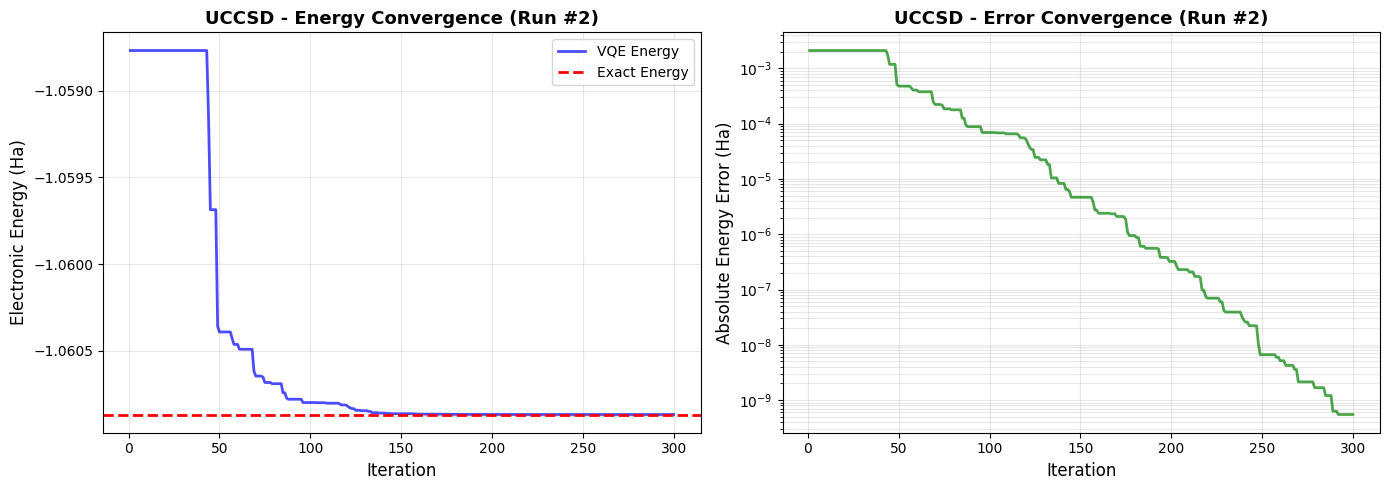

✅ Convergence plot saved: convergence_UCCSD_run2.png


⏱️  Progress: 2/15 complete
   Elapsed: 4.0 min | Estimated remaining: 26.0 min


################################################################################
BENCHMARK 3/15
Ansatz: UCCSD | Run: 3/3
################################################################################

Running: UCCSD - Run #3
Optimizer: COBYLA (maxiter=300)
Parameters: 15, Depth: 16
    Eval 50: E=-1.059178 Ha, Error=1.691 mHa
    Eval 100: E=-1.060802 Ha, Error=0.066 mHa
    Eval 150: E=-1.060866 Ha, Error=0.002 mHa
    Eval 200: E=-1.060868 Ha, Error=0.000 mHa
    Eval 250: E=-1.060868 Ha, Error=0.000 mHa
    Eval 300: E=-1.060868 Ha, Error=0.000 mHa

✅ Completed in 110.7s
   Function evaluations: 300
   Callback captured: 300 points
   Energy Error: 1.914931e-09 Ha (0.0000%)
   Fidelity: 1.000000
   Convergence: 113/300 iterations

⏱️  Progress: 3/15 complete
   Elapsed: 5.9 min | Estimated remaining: 23.4 min


###################################

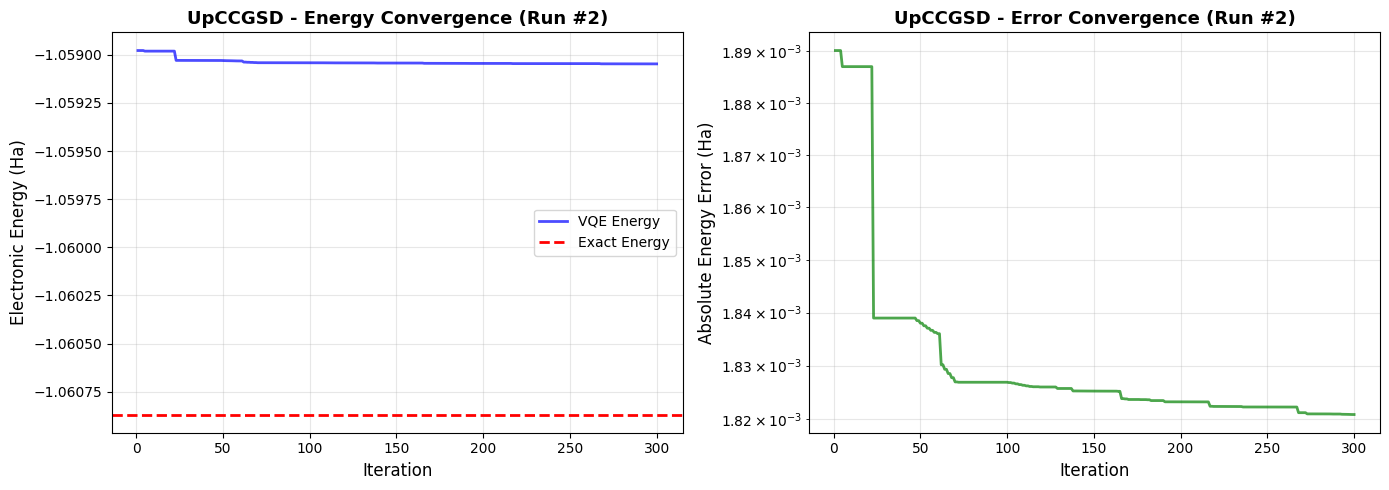

✅ Convergence plot saved: convergence_UpCCGSD_run2.png


⏱️  Progress: 5/15 complete
   Elapsed: 14.7 min | Estimated remaining: 29.4 min


################################################################################
BENCHMARK 6/15
Ansatz: UpCCGSD | Run: 3/3
################################################################################

Running: UpCCGSD - Run #3
Optimizer: COBYLA (maxiter=300)
Parameters: 36, Depth: 37
    Eval 50: E=-1.049226 Ha, Error=11.642 mHa
    Eval 100: E=-1.036880 Ha, Error=23.988 mHa
    Eval 150: E=-1.059014 Ha, Error=1.854 mHa
    Eval 200: E=-1.059026 Ha, Error=1.842 mHa
    Eval 250: E=-1.059033 Ha, Error=1.835 mHa
    Eval 300: E=-1.058294 Ha, Error=2.574 mHa

✅ Completed in 266.1s
   Function evaluations: 300
   Callback captured: 300 points
   Energy Error: 1.833016e-03 Ha (0.1728%)
   Fidelity: 0.996947
   Convergence: 300/300 iterations

⏱️  Progress: 6/15 complete
   Elapsed: 19.1 min | Estimated remaining: 28.7 min


#########################

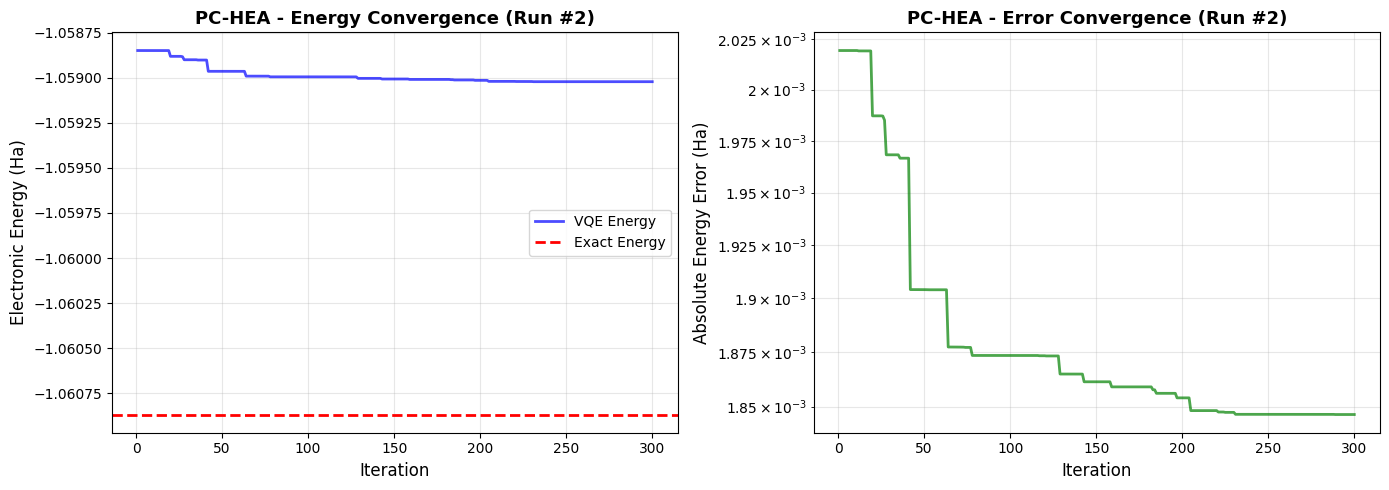

✅ Convergence plot saved: convergence_PC-HEA_run2.png


⏱️  Progress: 8/15 complete
   Elapsed: 19.2 min | Estimated remaining: 16.8 min


################################################################################
BENCHMARK 9/15
Ansatz: PC-HEA | Run: 3/3
################################################################################

Running: PC-HEA - Run #3
Optimizer: COBYLA (maxiter=300)
Parameters: 96, Depth: 32
    Eval 50: E=-1.058936 Ha, Error=1.932 mHa
    Eval 100: E=-0.941493 Ha, Error=119.375 mHa
    Eval 150: E=-0.919091 Ha, Error=141.777 mHa
    Eval 200: E=-0.925029 Ha, Error=135.839 mHa
    Eval 250: E=-0.701730 Ha, Error=359.138 mHa
    Eval 300: E=-0.930871 Ha, Error=129.997 mHa

✅ Completed in 3.1s
   Function evaluations: 300
   Callback captured: 300 points
   Energy Error: 1.863853e-03 Ha (0.1757%)
   Fidelity: 0.996827
   Convergence: 300/300 iterations

⏱️  Progress: 9/15 complete
   Elapsed: 19.3 min | Estimated remaining: 12.9 min


######################

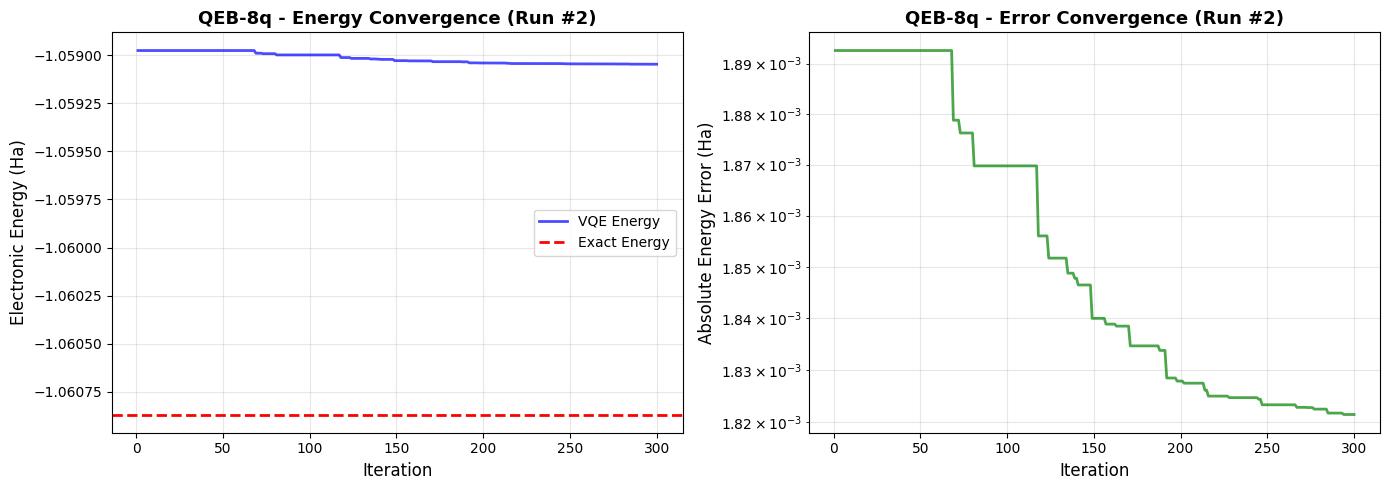

✅ Convergence plot saved: convergence_QEB-8q_run2.png


⏱️  Progress: 11/15 complete
   Elapsed: 19.4 min | Estimated remaining: 7.1 min


################################################################################
BENCHMARK 12/15
Ansatz: QEB-8q | Run: 3/3
################################################################################

Running: QEB-8q - Run #3
Optimizer: COBYLA (maxiter=300)
Parameters: 50, Depth: 149
    Eval 50: E=-1.048212 Ha, Error=12.656 mHa
    Eval 100: E=-1.058170 Ha, Error=2.698 mHa
    Eval 150: E=-1.059005 Ha, Error=1.864 mHa
    Eval 200: E=-1.059008 Ha, Error=1.860 mHa
    Eval 250: E=-1.059047 Ha, Error=1.821 mHa
    Eval 300: E=-1.059050 Ha, Error=1.819 mHa

✅ Completed in 3.6s
   Function evaluations: 300
   Callback captured: 300 points
   Energy Error: 1.818179e-03 Ha (0.1714%)
   Fidelity: 0.997036
   Convergence: 300/300 iterations

⏱️  Progress: 12/15 complete
   Elapsed: 19.5 min | Estimated remaining: 4.9 min

⚠️  QEB-4q uses a different pi

In [10]:
# Run all benchmarks by iterating through the ansatz dictionary
all_results = []
total_benchmarks = len(ansatz_dict) * NUM_RUNS
current_benchmark = 0

print("="*80)
print(f"STARTING COMPREHENSIVE BENCHMARK SUITE")
print(f"Total benchmarks to run: {total_benchmarks}")
print(f"Estimated time: {total_benchmarks * 3:.0f}-{total_benchmarks * 5:.0f} minutes")
print("="*80)

benchmark_start_time = time.time()

# Iterate through the ansatz dictionary
for ansatz_name, ansatz in ansatz_dict.items():
    
    if ansatz_name == "QEB-4q":
        print(f"\n" + "="*60)
        print(f"⚠️  QEB-4q uses a different pipeline (4-qubit projected H)")
        print(f"   Skipping in this benchmark loop, will run separately")
        print("="*60)
        continue  # Skip to next ansatz
    # ========================================================================
    
    for run_num in range(1, NUM_RUNS + 1):
        current_benchmark += 1
        
        print(f"\n\n{'#'*80}")
        print(f"BENCHMARK {current_benchmark}/{total_benchmarks}")
        print(f"Ansatz: {ansatz_name} | Run: {run_num}/{NUM_RUNS}")
        print(f"{'#'*80}")
        
        # Run benchmark with the ansatz from dictionary
        result = run_vqe_benchmark(
            ansatz=ansatz,
            ansatz_name=ansatz_name,
            run_number=run_num,
            qubit_op=qubit_op,
            exact_electronic=exact_electronic,
            exact_state=exact_state,
            problem=problem,
            maxiter=300
        )
        
        all_results.append(result)
        
        # Progress update
        elapsed = time.time() - benchmark_start_time
        avg_time_per_run = elapsed / current_benchmark
        remaining = (total_benchmarks - current_benchmark) * avg_time_per_run
        print(f"\n⏱️  Progress: {current_benchmark}/{total_benchmarks} complete")
        print(f"   Elapsed: {elapsed/60:.1f} min | Estimated remaining: {remaining/60:.1f} min")

total_time = time.time() - benchmark_start_time

print(f"\n\n{'='*80}")
print(f"🎉 ALL BENCHMARKS COMPLETE!")
print(f"{'='*80}")
print(f"Total time: {total_time/60:.1f} minutes ({total_time:.0f} seconds)")
print(f"Average time per benchmark: {total_time/total_benchmarks:.1f} seconds")
print(f"Total runs: {len(all_results)}")
print(f"Ansätze tested: {', '.join(ansatz_dict.keys())}")
print(f"{'='*80}\n")



## Step 6b: Run QEB Ansatz Benchmark (Special Pipeline)



RUNNING QEB ANSATZ BENCHMARK
QEB uses a 4-qubit projected Hamiltonian (1α+1β sector)
This requires a different pipeline than the standard 8-qubit ansätze

4-qubit Hamiltonian: 4 qubits, 16 Pauli terms
Exact energy (4q):   -0.91884618 Ha
Exact energy (8q):   -1.06086814 Ha
Difference:          1.420e-01 Ha


QEB Ansatz - Run 1/3
Ansatz parameters: 12
Ansatz depth:      3

Running VQE with COBYLA (maxiter=300)...
Note: COBYLA evaluates multiple trial points per iteration


/var/folders/54/sksfdtfn0s1c8w70qkdglf5r0000gq/T/ipykernel_34758/45325799.py:52: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz_qeb = TwoLocal(



Results:
  Electronic energy:  -0.91884618 Ha
  Total energy:       0.07647146 Ha
  Error vs exact (4q): 1.523e-13 Ha
  Total evaluations:   300 (raw)
  Best-so-far points:  300
  Time:                0.52 s

QEB Ansatz - Run 2/3
Ansatz parameters: 12
Ansatz depth:      3

Running VQE with COBYLA (maxiter=300)...
Note: COBYLA evaluates multiple trial points per iteration

Results:
  Electronic energy:  -0.91884618 Ha
  Total energy:       0.07647146 Ha
  Error vs exact (4q): 1.213e-12 Ha
  Total evaluations:   300 (raw)
  Best-so-far points:  300
  Time:                0.42 s

  📊 Run 2 Detailed Error Analysis:
     Absolute energy error: 0.00000000 Ha
     Energy error %:        0.000000%
     Final VQE energy:      -0.91884618 Ha
     Exact energy:          -0.91884618 Ha

📊 PLOTTING CONVERGENCE FOR QEB - RUN #2


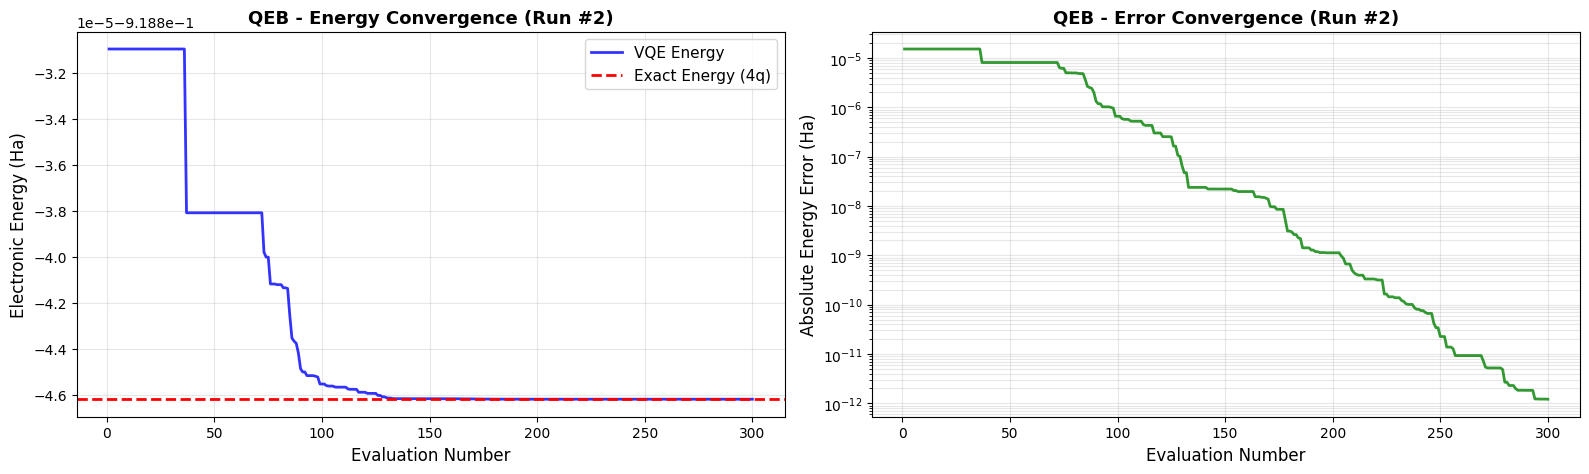


✅ Convergence plots saved to: convergence_QEB_run2.png
   Total Evaluations:       300
   Best-so-far tracked:     300
   Exact Energy (4q):       -0.9188461788 Ha
   Initial Error:           1.5224351303e-05 Ha
   Final Error:             1.2125855875e-12 Ha
   Error Reduction:         12555279.78x

QEB Ansatz - Run 3/3
Ansatz parameters: 12
Ansatz depth:      3

Running VQE with COBYLA (maxiter=300)...
Note: COBYLA evaluates multiple trial points per iteration

Results:
  Electronic energy:  -0.91884618 Ha
  Total energy:       0.07647146 Ha
  Error vs exact (4q): 1.399e-13 Ha
  Total evaluations:   246 (raw)
  Best-so-far points:  246
  Time:                0.35 s

✅ QEB Benchmark Complete!
Total ansätze tested: 1
Total runs in all_results: 15


In [11]:
# ==============================================================
# QEB Ansatz Benchmark (Special 4-Qubit Projected Hamiltonian Pipeline). now using 8-qubit so dont need this
# ==============================================================

print("\n" + "="*70)
print("RUNNING QEB ANSATZ BENCHMARK")
print("="*70)
print("QEB uses a 4-qubit projected Hamiltonian (1α+1β sector)")
print("This requires a different pipeline than the standard 8-qubit ansätze\n")

# Import additional requirements for QEB
from qiskit.quantum_info import Operator, SparsePauliOp

# Project into (1 alpha, 1 beta) sector
Hmat = qubit_op.to_matrix()
dim_full = Hmat.shape[0]
n_qubits = int(np.round(np.log2(dim_full)))

alpha_qubits = list(range(0, n_qubits, 2))
beta_qubits = list(range(1, n_qubits, 2))

basis_indices = []
for a in alpha_qubits:
    for b in beta_qubits:
        idx = (1 << a) | (1 << b)
        basis_indices.append(idx)

basis_indices = np.array(basis_indices, dtype=int)
Heff = Hmat[np.ix_(basis_indices, basis_indices)]

# Re-encode as 4-qubit Hamiltonian
H4_op = Operator(Heff)
H4_pauli = SparsePauliOp.from_operator(H4_op)

print(f"4-qubit Hamiltonian: {H4_pauli.num_qubits} qubits, {len(H4_pauli)} Pauli terms")

# Get exact solution for 4-qubit H
numpy_result4 = numpy_solver.compute_minimum_eigenvalue(H4_pauli)
exact_electronic_4 = numpy_result4.eigenvalue.real

print(f"Exact energy (4q):   {exact_electronic_4:.8f} Ha")
print(f"Exact energy (8q):   {exact_electronic:.8f} Ha")
print(f"Difference:          {abs(exact_electronic_4 - exact_electronic):.3e} Ha\n")

# Run QEB ansatz 3 times
for run_num in range(1, NUM_RUNS + 1):
    print(f"\n{'='*60}")
    print(f"QEB Ansatz - Run {run_num}/{NUM_RUNS}")
    print(f"{'='*60}")
    
    # Create TwoLocal ansatz for 4 qubits
    ansatz_qeb = TwoLocal(
        num_qubits=4,
        rotation_blocks='ry',
        entanglement='full',
        reps=2,
    )
    
    print(f"Ansatz parameters: {ansatz_qeb.num_parameters}")
    print(f"Ansatz depth:      {ansatz_qeb.decompose().depth()}")
    
    # Track convergence with best-so-far
    convergence_history = []
    all_evaluations = []
    best_energy = [float('inf')]
    variance_history = []
    start_time = time.time()
    
    def callback_qeb(eval_count, parameters, mean, std):
        """Callback with best-so-far tracking"""
        # Store all evaluations
        all_evaluations.append(mean)
        
        # Update best-so-far
        if mean < best_energy[0]:
            best_energy[0] = mean
        
        convergence_history.append(best_energy[0])
        
        # Handle std as dict or scalar
        if isinstance(std, dict):
            variance_val = list(std.values())[0] if std else 0.0
        else:
            variance_val = std if std is not None else 0.0
        variance_history.append(variance_val)
    
    # Run VQE with COBYLA (300 iterations)
    optimizer = COBYLA(maxiter=300, tol=1e-6)
    
    vqe_solver = VQE(
        StatevectorEstimator(),
        ansatz_qeb,
        optimizer,
        callback=callback_qeb,
    )
    
    initial_point = 0.01 * np.random.randn(ansatz_qeb.num_parameters)
    vqe_solver.initial_point = initial_point
    
    print("\nRunning VQE with COBYLA (maxiter=300)...")
    print("Note: COBYLA evaluates multiple trial points per iteration")
    
    result_qeb = vqe_solver.compute_minimum_eigenvalue(H4_pauli)
    
    vqe_elec_4 = result_qeb.eigenvalue.real
    vqe_total_4 = vqe_elec_4 + problem.nuclear_repulsion_energy
    elapsed = time.time() - start_time
    
    print(f"\nResults:")
    print(f"  Electronic energy:  {vqe_elec_4:.8f} Ha")
    print(f"  Total energy:       {vqe_total_4:.8f} Ha")
    print(f"  Error vs exact (4q): {abs(vqe_elec_4 - exact_electronic_4):.3e} Ha")
    print(f"  Total evaluations:   {len(all_evaluations)} (raw)")
    print(f"  Best-so-far points:  {len(convergence_history)}")
    print(f"  Time:                {elapsed:.2f} s")
    
    if run_num == 2:
        abs_error = abs(vqe_elec_4 - exact_electronic_4)
        error_pct = (abs_error / abs(exact_electronic_4)) * 100
        print(f"\n  📊 Run 2 Detailed Error Analysis:")
        print(f"     Absolute energy error: {abs_error:.8f} Ha")
        print(f"     Energy error %:        {error_pct:.6f}%")
        print(f"     Final VQE energy:      {vqe_elec_4:.8f} Ha")
        print(f"     Exact energy:          {exact_electronic_4:.8f} Ha")
        
        # Generate convergence plots for QEB Run 2
        print(f"\n📊 PLOTTING CONVERGENCE FOR QEB - RUN #2")
        print("="*70)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Plot 1: Energy convergence
        iterations = range(1, len(convergence_history) + 1)
        ax1.plot(iterations, convergence_history, 'b-', linewidth=2, alpha=0.8, label='VQE Energy')
        ax1.axhline(y=exact_electronic_4, color='r', linestyle='--', linewidth=2, label='Exact Energy (4q)')
        ax1.set_xlabel('Evaluation Number', fontsize=12)
        ax1.set_ylabel('Electronic Energy (Ha)', fontsize=12)
        ax1.set_title(f'QEB - Energy Convergence (Run #2)', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Error convergence (log scale)
        absolute_errors = [abs(energy - exact_electronic_4) for energy in convergence_history]
        ax2.semilogy(iterations, absolute_errors, 'g-', linewidth=2, alpha=0.8)
        ax2.set_xlabel('Evaluation Number', fontsize=12)
        ax2.set_ylabel('Absolute Energy Error (Ha)', fontsize=12)
        ax2.set_title(f'QEB - Error Convergence (Run #2)', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, which='both')
        
        plt.tight_layout()
        plot_filename = f"convergence_QEB_run2.png"
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✅ Convergence plots saved to: {plot_filename}")
        print(f"   Total Evaluations:       {len(all_evaluations)}")
        print(f"   Best-so-far tracked:     {len(convergence_history)}")
        print(f"   Exact Energy (4q):       {exact_electronic_4:.10f} Ha")
        print(f"   Initial Error:           {abs(convergence_history[0] - exact_electronic_4):.10e} Ha")
        print(f"   Final Error:             {abs_error:.10e} Ha")
        print(f"   Error Reduction:         {abs(convergence_history[0] - exact_electronic_4) / abs_error:.2f}x")
        print("="*70)
    
    # Store results (matching schema from run_vqe_benchmark)
    # Calculate state fidelity for QEB
    try:
        final_circuit = ansatz_qeb.assign_parameters(result_qeb.optimal_parameters)
        final_vqe_state_qeb = Statevector(final_circuit)
        # Get exact state for 4-qubit system
        exact_state_4 = Statevector.from_int(0, dims=(2,)*4)  # Placeholder - ideally compute from H4
        final_fidelity = state_fidelity(final_vqe_state_qeb, exact_state_4)
    except:
        final_fidelity = 0.0  # Fallback if fidelity calculation fails
    
    # Find 99% convergence point
    energy_range = convergence_history[0] - exact_electronic_4 if len(convergence_history) > 0 else 1.0
    threshold_99 = exact_electronic_4 + 0.01 * energy_range
    convergence_99_iter = len(convergence_history)
    for idx, energy in enumerate(convergence_history):
        if energy <= threshold_99:
            convergence_99_iter = idx + 1
            break
    
    result_dict = {
        'Ansatz': 'QEB',
        'Run': float(run_num),
        'CNOT_Count': float(ansatz_qeb.decompose().count_ops().get('cx', 0)),
        'Circuit_Depth': float(ansatz_qeb.decompose().depth()),
        'Circuit_Size': float(ansatz_qeb.decompose().size()),
        'Num_Parameters': float(ansatz_qeb.num_parameters),
        'Total_Iterations': float(len(all_evaluations)),
        'Convergence_Speed_99': float(convergence_99_iter),
        'Total_Time_sec': elapsed,
        'Initial_Energy_Ha': convergence_history[0] if len(convergence_history) > 0 else 0.0,
        'Final_Energy_Ha': vqe_elec_4,
        'Exact_Energy_Ha': exact_electronic_4,
        'Energy_Error_Ha': abs(vqe_elec_4 - exact_electronic_4),
        'Energy_Error_Percent': (abs(vqe_elec_4 - exact_electronic_4) / abs(exact_electronic_4)) * 100,
        'State_Fidelity': final_fidelity,
        'Fidelity_Percent': final_fidelity * 100,
        'Avg_Variance': np.mean(variance_history) if variance_history else 0.0,
        'Final_Variance': np.mean(variance_history[-100:]) if len(variance_history) > 100 else (np.mean(variance_history) if variance_history else 0.0),
        'Max_Variance': max(variance_history) if variance_history else 0.0,
        'Min_Variance': min(variance_history) if variance_history else 0.0,
        'Gradient_Indicator': 0.0,  # QEB doesn't track gradients
        'Mean_Gradient': 0.0,
        'Std_Gradient': 0.0,
        'Barren_Plateau_Status': 'N/A',
        '_convergence_history': convergence_history,
        '_all_evaluations': all_evaluations,
        '_note': 'Uses 4-qubit projected Hamiltonian'
    }
    
    all_results.append(result_dict)

print(f"\n✅ QEB Benchmark Complete!")
# Safe check for total ansätze
try:
    unique_ansatze = set([r.get('ansatz_name', 'Unknown') for r in all_results if isinstance(r, dict)])
    print(f"Total ansätze tested: {len(unique_ansatze)}")
except Exception as e:
    print(f"Total ansätze tested: Unable to determine")
print(f"Total runs in all_results: {len(all_results)}")


## Step 7: Aggregate and Analyze Results


In [12]:
# Create DataFrame from all results
results_df = pd.DataFrame([{k: v for k, v in r.items() if not k.startswith('_')} for r in all_results])

# Display full results table
print("="*100)
print("COMPLETE BENCHMARK RESULTS (All Runs)")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Save complete results
results_df.to_csv("benchmark_results_all_runs.csv", index=False)
print(f"\n✅ Complete results saved to: benchmark_results_all_runs.csv")


COMPLETE BENCHMARK RESULTS (All Runs)
 Ansatz  Run  CNOT_Count  Circuit_Depth  Circuit_Size  Num_Parameters  Total_Iterations  Convergence_Speed_99  Total_Time_sec  Initial_Energy_Ha  Final_Energy_Ha  Exact_Energy_Ha  Energy_Error_Ha  Energy_Error_Percent  State_Fidelity  Fidelity_Percent  Avg_Variance  Final_Variance  Max_Variance  Min_Variance  Gradient_Indicator  Mean_Gradient  Std_Gradient Barren_Plateau_Status
  UCCSD  1.0         0.0           16.0          17.0            15.0             300.0                  99.0      120.165711          -1.058211        -1.060868        -1.060868     4.501972e-10          4.243668e-08        1.000000        100.000000           0.0             0.0           0.0           0.0                 0.0            0.0           0.0                   N/A
  UCCSD  2.0         0.0           16.0          17.0            15.0             300.0                 131.0      118.183782          -1.058768        -1.060868        -1.060868     5.481957e-10     

In [13]:
# Calculate aggregated statistics (mean and std across 3 runs for each ansatz)
agg_stats = results_df.groupby('Ansatz').agg({
    'CNOT_Count': ['mean', 'std'],
    'Circuit_Depth': ['mean', 'std'],
    'Circuit_Size': ['mean', 'std'],
    'Num_Parameters': 'first',  # Same for all runs
    'Total_Iterations': ['mean', 'std'],
    'Convergence_Speed_99': ['mean', 'std'],
    'Total_Time_sec': ['mean', 'std'],
    'Energy_Error_Ha': ['mean', 'std'],
    'Energy_Error_Percent': ['mean', 'std'],
    'State_Fidelity': ['mean', 'std'],
    'Fidelity_Percent': ['mean', 'std'],
    'Avg_Variance': ['mean', 'std'],
    'Gradient_Indicator': ['mean', 'std'],
    'Barren_Plateau_Status': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).round(6)

# Flatten column names
agg_stats.columns = ['_'.join(col).strip('_') for col in agg_stats.columns.values]

print("\n" + "="*100)
print("AGGREGATED STATISTICS (Mean ± Std across 3 runs)")
print("="*100)
print(agg_stats.to_string())
print("="*100)

# Save aggregated statistics
agg_stats.to_csv("benchmark_results_aggregated.csv")
print(f"\n✅ Aggregated statistics saved to: benchmark_results_aggregated.csv")



AGGREGATED STATISTICS (Mean ± Std across 3 runs)
         CNOT_Count_mean  CNOT_Count_std  Circuit_Depth_mean  Circuit_Depth_std  Circuit_Size_mean  Circuit_Size_std  Num_Parameters_first  Total_Iterations_mean  Total_Iterations_std  Convergence_Speed_99_mean  Convergence_Speed_99_std  Total_Time_sec_mean  Total_Time_sec_std  Energy_Error_Ha_mean  Energy_Error_Ha_std  Energy_Error_Percent_mean  Energy_Error_Percent_std  State_Fidelity_mean  State_Fidelity_std  Fidelity_Percent_mean  Fidelity_Percent_std  Avg_Variance_mean  Avg_Variance_std  Gradient_Indicator_mean  Gradient_Indicator_std Barren_Plateau_Status_<lambda>
Ansatz                                                                                                                                                                                                                                                                                                                                                                               

In [14]:
# Create comparison summary table with key metrics
comparison_df = results_df.groupby('Ansatz').agg({
    'CNOT_Count': 'mean',
    'Circuit_Depth': 'mean',
    'Num_Parameters': 'first',
    'Convergence_Speed_99': 'mean',
    'Total_Time_sec': 'mean',
    'Energy_Error_Percent': 'mean',
    'State_Fidelity': 'mean',
    'Gradient_Indicator': 'mean',
    'Barren_Plateau_Status': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).round(4)

# Rename columns for clarity
comparison_df.columns = [
    'Avg_CNOT',
    'Avg_Depth',
    'Parameters',
    'Conv_Speed_99%',
    'Avg_Time(s)',
    'Avg_Error(%)',
    'Avg_Fidelity',
    'Avg_Gradient',
    'Plateau_Status'
]

# Calculate rankings
comparison_df['CNOT_Rank'] = comparison_df['Avg_CNOT'].rank()
comparison_df['Error_Rank'] = comparison_df['Avg_Error(%)'].rank()
comparison_df['Fidelity_Rank'] = comparison_df['Avg_Fidelity'].rank(ascending=False)
comparison_df['Time_Rank'] = comparison_df['Avg_Time(s)'].rank()
comparison_df['Overall_Rank'] = (
    comparison_df['CNOT_Rank'] + 
    comparison_df['Error_Rank'] + 
    comparison_df['Fidelity_Rank'] + 
    comparison_df['Time_Rank']
) / 4

# Sort by overall rank
comparison_df = comparison_df.sort_values('Overall_Rank')

print("\n" + "="*100)
print("ANSATZ COMPARISON SUMMARY (Averaged across 3 runs)")
print("="*100)
print(comparison_df.to_string())
print("\n" + "="*100)
print("RANKINGS (1 = Best):")
print("  - Lower CNOT count is better (fewer gates)")
print("  - Lower error is better (more accurate)")
print("  - Higher fidelity is better (closer to exact state)")
print("  - Lower time is better (faster convergence)")
print("  - Overall rank is average of all rankings")
print("="*100)

# Save comparison
comparison_df.to_csv("benchmark_comparison_summary.csv")
print(f"\n✅ Comparison summary saved to: benchmark_comparison_summary.csv")



ANSATZ COMPARISON SUMMARY (Averaged across 3 runs)
         Avg_CNOT  Avg_Depth  Parameters  Conv_Speed_99%  Avg_Time(s)  Avg_Error(%)  Avg_Fidelity  Avg_Gradient Plateau_Status  CNOT_Rank  Error_Rank  Fidelity_Rank  Time_Rank  Overall_Rank
Ansatz                                                                                                                                                                                       
QEB           0.0        3.0        12.0        122.3333       0.4263        0.0000        1.0000           0.0            N/A        2.5         1.5            1.5        1.0         1.625
UCCSD         0.0       16.0        15.0        114.3333     116.3663        0.0000        1.0000           0.0            N/A        2.5         1.5            1.5        4.0         2.375
PC-HEA        0.0       32.0        96.0        300.0000       2.9805        0.1758        0.9969           0.0            N/A        2.5         5.0            5.0        2.0         3.62

## Step 8: Comprehensive Visualizations


Plotting ansätze: ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB']


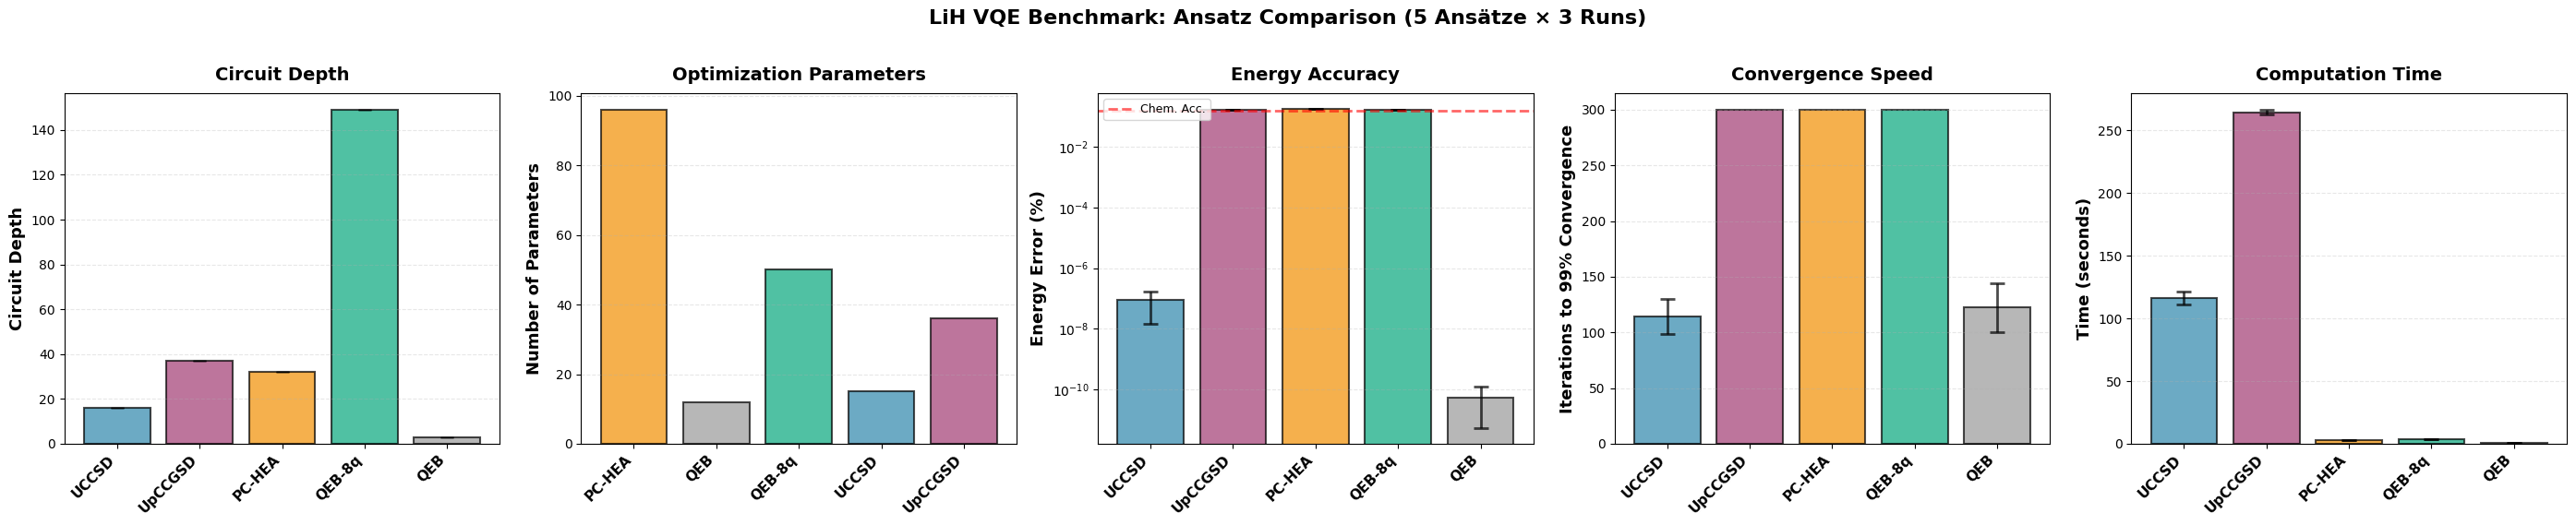

Results check:

UCCSD:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 116.37 sec
  Avg Error: 0.000000%
  Avg Iters: 300
  Circuit Depth: 16

UpCCGSD:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 264.51 sec
  Avg Error: 0.171981%
  Avg Iters: 300
  Circuit Depth: 37

PC-HEA:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 2.98 sec
  Avg Error: 0.175762%
  Avg Iters: 300
  Circuit Depth: 32

QEB-8q:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 3.56 sec
  Avg Error: 0.171504%
  Avg Iters: 300
  Circuit Depth: 149

QEB-4q:
  Rows: 0
  Runs: []
  Avg Time: nan sec
  Avg Error: nan%
  Avg Iters: nan
  Circuit Depth: nan

Convergence check:
PC-HEA: 0 evaluations
QEB-8q: 0 evaluations


IndexError: single positional indexer is out-of-bounds

In [17]:

# =============================================================================
# STEP 8: COMPARISON PLOTS 
# =============================================================================

ansatz_names = list(ansatz_dict.keys())
ansatz_names_with_data = results_df['Ansatz'].unique().tolist()
ansatz_names_with_data = [name for name in ansatz_names_with_data if pd.notna(name)]
print(f"Plotting ansätze: {ansatz_names_with_data}")

# Define specific colors for each ansatz (consistent coloring)
color_map = {
    'UCCSD': '#2E86AB',      # Blue
    'UpCCGSD': '#A23B72',    # Purple
    'PC-HEA': '#F18F01',     # Orange
    'QEB-8q': '#06A77D',     # Green
    'QEB-4q': '#C73E1D'      # Red
}

# Create figure: 1 ROW, 5 COLUMNS 
fig, axes = plt.subplots(1, 5, figsize=(28, 6))

# ============================================================================
# PLOT 1: Circuit Depth
# ============================================================================
ax = axes[0]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Circuit_Depth']
    ax.bar(i, data.mean(), yerr=data.std(), color=color_map.get(ansatz, '#999999'), 
           alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Circuit Depth', fontsize=13, fontweight='bold')
ax.set_title('Circuit Depth', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 2: Number of Parameters
# ============================================================================
ax = axes[1]
params_data = results_df.groupby('Ansatz')['Num_Parameters'].first()
ax.bar(range(len(params_data)), params_data.values, 
       color=[color_map.get(a, '#999999') for a in params_data.index], 
       alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(params_data.index, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Parameters', fontsize=13, fontweight='bold')
ax.set_title('Optimization Parameters', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 3: Energy Error 
# ============================================================================
ax = axes[2]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Energy_Error_Percent']
    # Filter valid data for log scale
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Add error bar with proper handling for log scale
        if pd.notna(std_val) and std_val > 0:
            # For log scale, use asymmetric error bars
            lower_err = mean_val - max(mean_val * 0.1, mean_val - std_val)
            upper_err = std_val
            ax.errorbar(i, mean_val, yerr=[[lower_err], [upper_err]], 
                       fmt='none', ecolor='black', capsize=6, capthick=2, 
                       elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Energy Error (%)', fontsize=13, fontweight='bold')
ax.set_title('Energy Accuracy', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', which='both', linestyle='--')
ax.set_yscale('log')
# Add chemical accuracy reference
ax.axhline(y=0.16, color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label='Chem. Acc.')
ax.legend(fontsize=9, loc='upper left')

# ============================================================================
# PLOT 4: Convergence Speed
# ============================================================================
ax = axes[3]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Convergence_Speed_99']
    # Filter valid data
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        if pd.notna(std_val) and std_val > 0:
            ax.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', 
                       capsize=6, capthick=2, elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Iterations to 99% Convergence', fontsize=13, fontweight='bold')
ax.set_title('Convergence Speed', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 5: Computation Time
# ============================================================================
ax = axes[4]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Total_Time_sec']
    # Filter valid data
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        if pd.notna(std_val) and std_val > 0:
            ax.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', 
                       capsize=6, capthick=2, elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Computation Time', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add footnote about QEB-4q if present
if 'QEB-4q' in ansatz_names_with_data:
    fig.text(0.5, 0.02, '* QEB-4q uses different 4-qubit Hamiltonian (not directly comparable to 8-qubit ansätze)', 
             ha='center', fontsize=10, style='italic', color='red', weight='bold')

# Overall title
plt.suptitle(f'LiH VQE Benchmark: Ansatz Comparison ({len(ansatz_names_with_data)} Ansätze × {NUM_RUNS} Runs)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig('benchmark_comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()


print("Results check:")
for ansatz in ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB-4q']:
    data = results_df[results_df['Ansatz'] == ansatz]
    print(f"\n{ansatz}:")
    print(f"  Rows: {len(data)}")
    print(f"  Runs: {data['Run'].unique()}")
    print(f"  Avg Time: {data['Total_Time_sec'].mean():.2f} sec")
    print(f"  Avg Error: {data['Energy_Error_Percent'].mean():.6f}%")
    print(f"  Avg Iters: {data['Total_Iterations'].mean():.0f}")
    print(f"  Circuit Depth: {data['Circuit_Depth'].mean():.0f}")

print("\nConvergence check:")
for ansatz in ['PC-HEA', 'QEB-8q', 'QEB-4q']:
    data = results_df[results_df['Ansatz'] == ansatz].iloc[0]
    conv_hist = data.get('_convergence_history', [])
    print(f"{ansatz}: {len(conv_hist)} evaluations")
    if len(conv_hist) > 0:
        print(f"  Initial: {conv_hist[0]:.6f} Ha")
        print(f"  Final: {conv_hist[-1]:.6f} Ha")


Plotting ansätze: ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB']


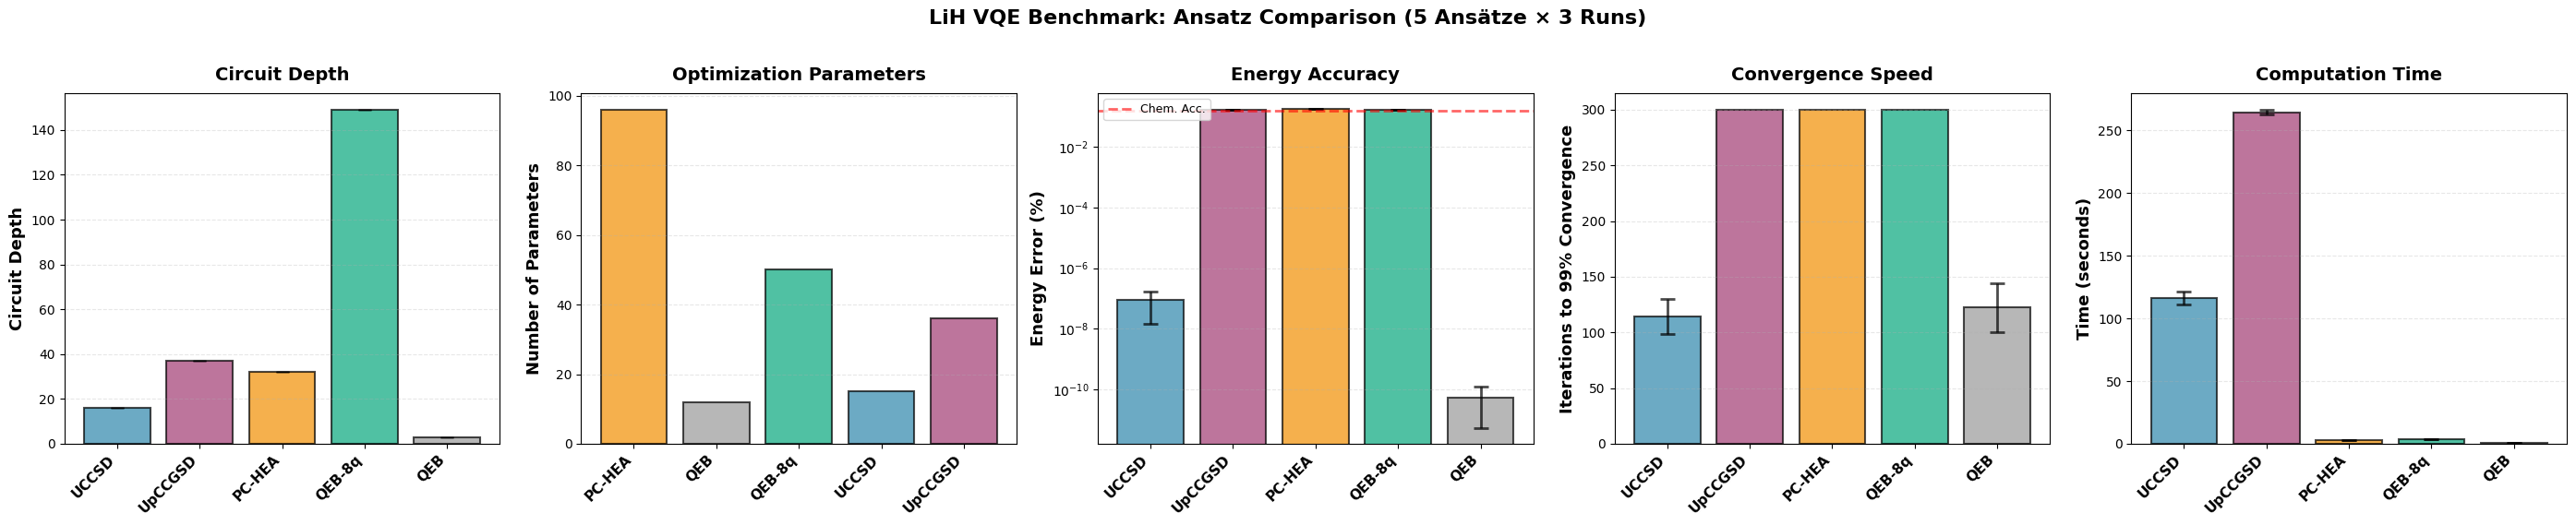

Results check:

UCCSD:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 116.37 sec
  Avg Error: 0.000000%
  Avg Iters: 300
  Circuit Depth: 16

UpCCGSD:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 264.51 sec
  Avg Error: 0.171981%
  Avg Iters: 300
  Circuit Depth: 37

PC-HEA:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 2.98 sec
  Avg Error: 0.175762%
  Avg Iters: 300
  Circuit Depth: 32

QEB-8q:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 3.56 sec
  Avg Error: 0.171504%
  Avg Iters: 300
  Circuit Depth: 149

QEB-4q:
  Rows: 0
  Runs: []
  Avg Time: nan sec
  Avg Error: nan%
  Avg Iters: nan
  Circuit Depth: nan

Convergence check:
PC-HEA: 0 evaluations
QEB-8q: 0 evaluations


IndexError: single positional indexer is out-of-bounds

In [16]:

# =============================================================================
# STEP 8: COMPARISON PLOTS 
# =============================================================================

ansatz_names = list(ansatz_dict.keys())
ansatz_names_with_data = results_df['Ansatz'].unique().tolist()
ansatz_names_with_data = [name for name in ansatz_names_with_data if pd.notna(name)]
print(f"Plotting ansätze: {ansatz_names_with_data}")

# Define specific colors for each ansatz (consistent coloring)
color_map = {
    'UCCSD': '#2E86AB',      # Blue
    'UpCCGSD': '#A23B72',    # Purple
    'PC-HEA': '#F18F01',     # Orange
    'QEB-8q': '#06A77D',     # Green
    'QEB-4q': '#C73E1D'      # Red
}

# Create figure: 1 ROW, 5 COLUMNS 
fig, axes = plt.subplots(1, 5, figsize=(28, 6))

# ============================================================================
# PLOT 1: Circuit Depth
# ============================================================================
ax = axes[0]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Circuit_Depth']
    ax.bar(i, data.mean(), yerr=data.std(), color=color_map.get(ansatz, '#999999'), 
           alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Circuit Depth', fontsize=13, fontweight='bold')
ax.set_title('Circuit Depth', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 2: Number of Parameters
# ============================================================================
ax = axes[1]
params_data = results_df.groupby('Ansatz')['Num_Parameters'].first()
ax.bar(range(len(params_data)), params_data.values, 
       color=[color_map.get(a, '#999999') for a in params_data.index], 
       alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(params_data.index, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Parameters', fontsize=13, fontweight='bold')
ax.set_title('Optimization Parameters', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 3: Energy Error 
# ============================================================================
ax = axes[2]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Energy_Error_Percent']
    # Filter valid data for log scale
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Add error bar with proper handling for log scale
        if pd.notna(std_val) and std_val > 0:
            # For log scale, use asymmetric error bars
            lower_err = mean_val - max(mean_val * 0.1, mean_val - std_val)
            upper_err = std_val
            ax.errorbar(i, mean_val, yerr=[[lower_err], [upper_err]], 
                       fmt='none', ecolor='black', capsize=6, capthick=2, 
                       elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Energy Error (%)', fontsize=13, fontweight='bold')
ax.set_title('Energy Accuracy', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', which='both', linestyle='--')
ax.set_yscale('log')
# Add chemical accuracy reference
ax.axhline(y=0.16, color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label='Chem. Acc.')
ax.legend(fontsize=9, loc='upper left')

# ============================================================================
# PLOT 4: Convergence Speed
# ============================================================================
ax = axes[3]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Convergence_Speed_99']
    # Filter valid data
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        if pd.notna(std_val) and std_val > 0:
            ax.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', 
                       capsize=6, capthick=2, elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Iterations to 99% Convergence', fontsize=13, fontweight='bold')
ax.set_title('Convergence Speed', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 5: Computation Time
# ============================================================================
ax = axes[4]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Total_Time_sec']
    # Filter valid data
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        if pd.notna(std_val) and std_val > 0:
            ax.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', 
                       capsize=6, capthick=2, elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Computation Time', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add footnote about QEB-4q if present
if 'QEB-4q' in ansatz_names_with_data:
    fig.text(0.5, 0.02, '* QEB-4q uses different 4-qubit Hamiltonian (not directly comparable to 8-qubit ansätze)', 
             ha='center', fontsize=10, style='italic', color='red', weight='bold')

# Overall title
plt.suptitle(f'LiH VQE Benchmark: Ansatz Comparison ({len(ansatz_names_with_data)} Ansätze × {NUM_RUNS} Runs)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig('benchmark_comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()


print("Results check:")
for ansatz in ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB-4q']:
    data = results_df[results_df['Ansatz'] == ansatz]
    print(f"\n{ansatz}:")
    print(f"  Rows: {len(data)}")
    print(f"  Runs: {data['Run'].unique()}")
    print(f"  Avg Time: {data['Total_Time_sec'].mean():.2f} sec")
    print(f"  Avg Error: {data['Energy_Error_Percent'].mean():.6f}%")
    print(f"  Avg Iters: {data['Total_Iterations'].mean():.0f}")
    print(f"  Circuit Depth: {data['Circuit_Depth'].mean():.0f}")

print("\nConvergence check:")
for ansatz in ['PC-HEA', 'QEB-8q', 'QEB-4q']:
    data = results_df[results_df['Ansatz'] == ansatz].iloc[0]
    conv_hist = data.get('_convergence_history', [])
    print(f"{ansatz}: {len(conv_hist)} evaluations")
    if len(conv_hist) > 0:
        print(f"  Initial: {conv_hist[0]:.6f} Ha")
        print(f"  Final: {conv_hist[-1]:.6f} Ha")
